In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.api import ExponentialSmoothing
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

orders = pl.read_csv('data/olist_orders_dataset.csv')
order_items = pl.read_csv('data/olist_order_items_dataset.csv')
order_payments = pl.read_csv('data/olist_order_payments_dataset.csv')
products = pl.read_csv('data/olist_products_dataset.csv')
product_categories = pl.read_csv('data/product_category_name_translation.csv')
customers = pl.read_csv('data/olist_customers_dataset.csv')
reviews = pl.read_csv('data/olist_order_reviews_dataset.csv')
sellers = pl.read_csv('data/olist_sellers_dataset.csv')

In [2]:
warnings.filterwarnings('ignore')

### **A three-month forecast of future sales (numbers and figures)**
---

##### **Visualize the time series**

In [352]:
# Calculate Monthly Sales
monthly_sales = (
    orders.select(['order_id', 'order_purchase_timestamp'])
    .join(
        order_items.select(['order_id', 'price']),
        on='order_id')
    .with_columns(
        (pl.col('order_purchase_timestamp').str.strptime(pl.Datetime).cast(pl.Date).dt.truncate("1mo").alias('purchase_month')))
    .drop(columns=['order_purchase_timestamp', 'order_id'])
    .groupby('purchase_month')
    .agg(pl.col('price').sum().alias('monthly_sales'))
    .sort('purchase_month')
    .filter((pl.col('purchase_month') < '2018-09-01') & (pl.col('purchase_month') >= '2017-01-01'))
    .to_pandas()
)

# Plot monthly sales
fig = px.line(
    monthly_sales, x='purchase_month', y='monthly_sales',
    template='simple_white', width=900, height=400,
    markers=True,
    labels={
        'purchase_month': 'Purchase Month',
        'monthly_sales': 'Sales'},
    title='Total Sales Amount by Month'
)

fig.update_traces(
    line_color='#B22222',
    line_width=2
)

fig.show()

#### **Forecast: ARIMA**

##### ACF & PACF Plots
In the below plots, I plot an autocorrlation (ACF) plot and a partial autocorrelation (PACF) plot. The tapering results of the ACF plot suggest that there is an AutoRegressive process in the data. The ACF also indicates that the data is not stationary. The PACF indicates that there is a lack of a Moving Average process in our data. 

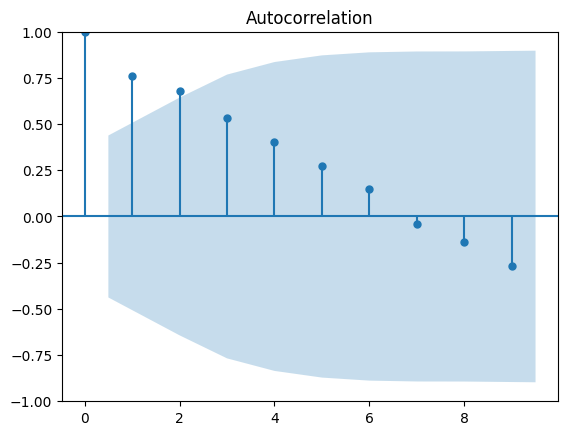

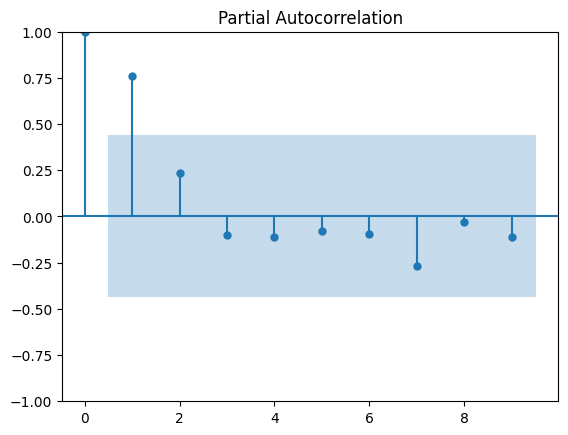

In [354]:
data = np.array(monthly_sales.drop(columns='purchase_month')['monthly_sales'])

fig_acf = plot_acf(data, lags=9)
fig_pacf = plot_pacf(data, lags=9, method='ywm')

##### Fit an ARIMA Model and Check the Residual ACF and Residual PACF
Using the residuals, we can iteratively test out different combinations of AR and Integration terms to check if we still see signs of an AR process
- Ultimately, I chose the combination of sensible terms that resulted in lowest AIC

502.92036456022385

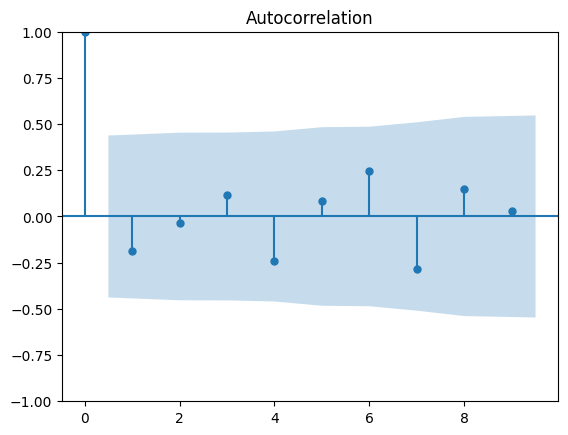

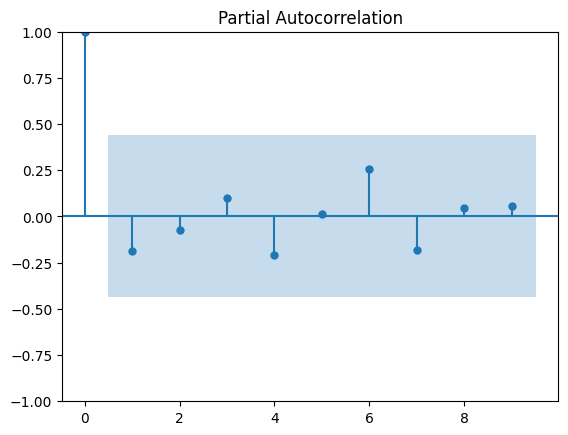

In [355]:
arima = sm.tsa.ARIMA(data, order=(2, 1, 0)).fit()

residual_acf = plot_acf(arima.resid, lags=9)
residual_pacf = plot_pacf(arima.resid, lags=9, method='ywm')

arima.aic

##### Make Predictions using the Fitted ARIMA Model

In [359]:
data = np.array(monthly_sales.drop(columns='purchase_month')['monthly_sales'])

predictions = pd.DataFrame([list(data) + list(arima.forecast(3)), ['Actuals']*len(data) + ['Forecasted']*3]).T
predictions.columns = ['monthly_sales', 'forecast']

fig = px.line(
    predictions, y='monthly_sales', color='forecast',
    template='simple_white', width=900, height=400, markers=True,
    color_discrete_map={
        'Actuals': '#B22222',
        'Forecasted': '#8d8d8d'},
    labels={
        'index': 'Sales Period',
        'monthly_sales': 'Sales',
        'forecast': 'Legend'},
    title='3 Month Forecast of Sales, ARIMA(1,1,0)'
)

fig.add_vrect(
        x0=len(data),
        x1=len(data) + 2,
        fillcolor="black",
        opacity=0.1,
        line_width=0,
)

fig.update_layout(
    font_color='black',
    title_font_color="black",
    legend_title_font_color="black"
)

# Print Forecasts and Plot
print(arima.forecast(3))
fig.show()

[875559.26144725 855117.81528907 867756.1575659 ]


### **Determine the three best selling categories, and create a forecast of growth in those categories**
---

##### Determine and plot the sales of the top 3 best selling categories

In [68]:
# Combine orders, order_items, and products
order_items_products = (
    orders.select(['order_id', 'order_purchase_timestamp'])
    .join(
        order_items.select(['order_id', 'product_id', 'price']),
        on='order_id')
    .join(
        products.select(['product_id', 'product_category_name']),
        on='product_id')
)

# Get the top 3 product categories by sales volume (sum of price)
top_categories_by_sales = (
    order_items_products.select(['product_category_name', 'price'])
    .groupby('product_category_name')
    .agg(pl.col('price').sum().alias('total_sales'))
    .sort(by='total_sales', reverse=True)
    .head(3)
)

top_3_categories = list(top_categories_by_sales['product_category_name'])

# Create a dataframe with monthly sales data for each of the top categories
top_products_detail = (
    order_items_products
    .filter(pl.col('product_category_name').is_in(top_3_categories))
    .with_columns(
        (pl.col('order_purchase_timestamp').str.strptime(pl.Datetime).cast(pl.Date).dt.truncate("1mo").alias('purchase_month')))
    .drop(columns='order_purchase_timestamp')
    .groupby(['purchase_month', 'product_category_name'])
    .agg(pl.col('price').sum().alias('total_sales'))
    .filter(pl.col('purchase_month') >= '2017-01-01')
    .sort(by=['product_category_name', 'purchase_month'])
    .to_pandas()
)

# Plot the results over each month
fig = px.line(
    top_products_detail, x='purchase_month', y='total_sales',
    color='product_category_name', markers=False, width=900, height=400,
    color_discrete_map= {
        "beleza_saude": "#010101",
        "relogios_presentes": "#8d8d8d",
        "cama_mesa_banho": '#B22222'},
    labels = {
        "purchase_month": "Purchase Month",
        "total_sales": "Total Sales",
        "product_category_name": "Product Category"},
    title='Monthly Sales of the Top 3 all-time Product Categories',
    template='simple_white'
)

fig.update_layout(
    font_color='black',
    title_font_color="black",
    legend_title_font_color="black"
)

fig.show()

##### Forecast EoY for each Product Category

In [69]:
# Convert Frame back to Polars
top_products_detail = pl.DataFrame(top_products_detail)

# Create and plot the forecasts for each product category
all_plots = []

for category, color in zip(['beleza_saude', 'relogios_presentes', 'cama_mesa_banho'], ['#010101', '#8d8d8d', '#B22222']):
    data = (
        top_products_detail
        .filter(pl.col('product_category_name') == category)
        .select(['total_sales', 'purchase_month'])
        .with_columns(pl.col('purchase_month').dt.month())
        .to_pandas())
    
    y = list(data['total_sales'])
    X = list(data['purchase_month'])
    
    model = sm.tsa.SARIMAX(y, order=(3, 1, 0), exog=X).fit()
    
    predictions = pd.DataFrame([y + list(model.forecast(4, exog=[9, 10, 11, 12])), ['Actuals']*len(y) + ['Forecasted']*4]).T
    predictions.columns = ['monthly_sales', 'forecast']
    fig = px.line(
        predictions, y='monthly_sales',
        template='simple_white', width=900, height=400, markers=True,
        color_discrete_map={
            'Actuals': '#B22222',
            'Forecasted': '#8d8d8d'
        })
    fig.add_vrect(
        x0=len(y),
        x1=len(y) + 2,
        fillcolor="black",
        opacity=0.1,
        line_width=0,
    )
    
    fig.update_traces(
        line_color=color,
        line_width=2
    )
    all_plots.append(fig)

fig1 = all_plots[0]
fig2 = all_plots[1]
fig3 = all_plots[2]

fig = go.Figure(data=fig1.data + fig2.data + fig3.data)

fig.update_layout(
    title="EoY Forecast for Top 3 Product Categories {Beauty & Health, Watches & Gifts, Bed Table & Bath}",
    template='simple_white',
    width=1100,
    xaxis_title='Periods',
    yaxis_title='Total Sales')

fig.add_vrect(
        x0=len(y),
        x1=len(y) + 3,
        fillcolor="black",
        opacity=0.1,
        line_width=0,
    )

fig.show()

## Determine the fastest-growing category, and create a forecast for its growth

---

In [82]:
baseline_period = '2017-01-01'

# Monthly Sales Aggregation per Product Category
monthly_sales_by_category = (
    orders.select(['order_id', 'order_purchase_timestamp'])
    .join(
        order_items.select(['order_id', 'product_id', 'price']),
        on='order_id')
    .join(
        products.select(['product_id', 'product_category_name']),
        on='product_id')
    .filter(pl.col('product_category_name').is_not_null())
    .with_columns(
        (pl.col('order_purchase_timestamp').str.strptime(pl.Datetime).cast(pl.Date).dt.truncate("1mo").alias('purchase_month')))
    .drop(columns='order_purchase_timestamp')
    .groupby(['purchase_month', 'product_category_name'])
    .agg([
        (pl.col('price').sum().alias('total_sales')),
        (pl.col('price').count().alias('total_transactions'))])
    .sort(by=['product_category_name', 'purchase_month'])
    .filter(pl.col('purchase_month') >= baseline_period)
    .to_pandas()
)

# Create a shifted column for sales and transactions to determine the vales for the previous month
monthly_sales_by_category['prev_sales'] = monthly_sales_by_category.groupby('product_category_name')['total_sales'].shift()
monthly_sales_by_category['prev_transactions'] = monthly_sales_by_category.groupby('product_category_name')['total_transactions'].shift()

# Create "baseline" columns that determine the value of sales and transactions in the first period of analysis
start_values = monthly_sales_by_category.groupby(['product_category_name']).agg({'total_sales': 'first', 'total_transactions': 'first'}).reset_index()
start_values.columns = ['product_category_name', 'starting_sales', 'starting_transactions']
monthly_sales_by_category = monthly_sales_by_category.merge(start_values, on='product_category_name')

end_values = monthly_sales_by_category.groupby(['product_category_name']).agg({'total_sales': 'last', 'total_transactions': 'last'}).reset_index()
end_values.columns = ['product_category_name', 'ending_sales', 'ending_transactions']
monthly_sales_by_category = monthly_sales_by_category.merge(end_values, on='product_category_name')

col_order = ['purchase_month', 'product_category_name', 'total_sales', 'prev_sales',
             'starting_sales', 'ending_sales', 'total_transactions', 'prev_transactions',
             'starting_transactions', 'ending_transactions']

monthly_sales_by_category = monthly_sales_by_category.reindex(columns=col_order)

monthly_sales_by_category

,purchase_month,product_category_name,total_sales,prev_sales,starting_sales,ending_sales,total_transactions,prev_transactions,starting_transactions,ending_transactions
0,2017-01-01,agro_industria_e_comercio,65.97,NaN,65.97,5021.09,3,NaN,3,18
1,2017-02-01,agro_industria_e_comercio,224.84,65.97,65.97,5021.09,7,3.0,3,18
2,2017-03-01,agro_industria_e_comercio,81.99,224.84,65.97,5021.09,2,7.0,3,18
3,2017-05-01,agro_industria_e_comercio,1579.94,81.99,65.97,5021.09,4,2.0,3,18
4,2017-06-01,agro_industria_e_comercio,1390.00,1579.94,65.97,5021.09,1,4.0,3,18
...,...,...,...,...,...,...,...,...,...,...
1222,2018-04-01,utilidades_domesticas,45405.96,37514.44,2827.58,60202.67,471,407.0,28,629
1223,2018-05-01,utilidades_domesticas,63003.57,45405.96,2827.58,60202.67,619,471.0,28,629
1224,2018-06-01,utilidades_domesticas,56825.45,63003.57,2827.58,60202.67,584,619.0,28,629
1225,2018-07-01,utilidades_domesticas,63409.14,56825.45,2827.58,60202.67,577,584.0,28,629


In [97]:
overall_growth = monthly_sales_by_category[['product_category_name', 'starting_sales', 'ending_sales']]
overall_growth['num_months'] = overall_growth.groupby(by=['product_category_name'])['product_category_name'].transform('count')
overall_growth = overall_growth.drop_duplicates().reset_index(drop=True)
overall_growth['overall_growth_rate'] = ((overall_growth['ending_sales'] - overall_growth['starting_sales']) / overall_growth['starting_sales']) * 100
overall_growth['monthly_growth_rate'] = (((overall_growth['ending_sales'] - overall_growth['starting_sales']) / overall_growth['starting_sales']) / overall_growth['num_months']) * 100
overall_growth.sort_values(by='monthly_growth_rate', ascending=False, inplace=True)
overall_growth.reset_index(drop=True)

,product_category_name,starting_sales,ending_sales,num_months,overall_growth_rate,monthly_growth_rate
0,alimentos,42.82,8256.18,20,19181.130313,959.056516
1,artes_e_artesanato,21.99,901.76,6,4000.773079,666.795513
2,agro_industria_e_comercio,65.97,5021.09,19,7511.171745,395.324829
3,construcao_ferramentas_construcao,310.00,22917.16,19,7292.632258,383.822750
4,portateis_casa_forno_e_cafe,71.90,2996.72,11,4067.899861,369.809078
...,...,...,...,...,...,...
68,dvds_blu_ray,29.80,8.90,20,-70.134228,-3.506711
69,tablets_impressao_imagem,792.00,50.00,17,-93.686869,-5.510992
70,flores,187.80,47.99,9,-74.446219,-8.271802
71,cds_dvds_musicais,225.00,65.00,6,-71.111111,-11.851852


In [103]:
top_growth_categories = list(overall_growth.head(5)['product_category_name'])
# Plot Monthly sales for the top growing categories based on the Median MoM growth rates
px.line(
    monthly_sales_by_category[monthly_sales_by_category['product_category_name'].isin(top_growth_categories)],
    x='purchase_month', y='total_sales', color='product_category_name', template='simple_white',
    markers='dot', render_mode='svg', width=1250, height=450, line_shape='spline', hover_data=['total_transactions'],
    title = "Monthly sales for the top growing categories based on the Median MoM growth rates"
)

Decision: Forecast Product Category construcao_ferramentas_construcao (Construction Tools)

In [117]:
data = list(monthly_sales_by_category[monthly_sales_by_category['product_category_name'] == 'construcao_ferramentas_construcao']['total_sales'])

model = ExponentialSmoothing(data, trend='add', damped_trend=True).fit(optimized=True)
trends = pd.DataFrame([data + list(model.forecast(4)), ['Actuals']*len(data) + ['Forecasted']*4]).T
trends.columns = ['monthly_sales', 'forecast']

fig = px.line(
    trends, y='monthly_sales', color='forecast',
    template='simple_white', width=900, height=400, markers=True,
    color_discrete_map={
        'Actuals': '#B22222',
        'Forecasted': '#8d8d8d'},
    labels={
        'index': 'Sales Period',
        'monthly_sales': 'Sales',
        'forecast': 'Legend'},
    line_shape='spline',
    title='EoY forecast for Product Category = Construction Tools and Construction'
)

fig.add_vrect(
        x0=len(data),
        x1=len(data) + 3,
        fillcolor="black",
        opacity=0.1,
        line_width=0,
)

fig.update_layout(
    font_color='black',
    title_font_color="black",
    legend_title_font_color="black"
)

# Print Forecasts and Plot
print(model.forecast(4))
fig.show()

[24254.89866361 26031.27308779 27780.04830778 29501.65312734]
